### Setup

In [ ]:
from IPython.display import Image

# If not using Azure Notebooks, install msticpy with
# !pip install msticpy
from msticpy.nbtools import nbinit
extra_imports = [
    "msticpy.nbtools.timeseries, display_timeseries_anomolies",
    "msticpy.analysis.timeseries, timeseries_anomalies_stl",
    "msticpy.nbtools.morph_charts, MorphCharts",
    "datetime, datetime"
]

nbinit.init_notebook(
    namespace=globals(),
    additional_packages=["pyvis"],
    extra_imports=extra_imports,
);

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

### Data Acquisition - Splunk

In [ ]:
splunk_prov = QueryProvider("Splunk")
splunk_prov.connect(host="splunk-mstic.westus2.cloudapp.azure.com", username="admin", password="xxx")

In [210]:
splunk_query = """
serach index='blackhat' sourcetype='network' earliest=0
| table TimeGenerated, TotalBytesSent
"""

stldemo = splunk_prov.exec_query(splunk_query)

NameError: name 'splunk_prov' is not defined

## Timeseries Analysis to detected Anomalies

In [49]:
stldemo = pd.read_csv(
   "networklogs.csv", index_col=["TimeGenerated"], usecols=["TimeGenerated","TotalBytesSent"], parse_dates=["TimeGenerated"], infer_datetime_format=True)
output = timeseries_anomalies_stl(stldemo)
display_timeseries_anomolies(data=output, y= 'TotalBytesSent')

Loading BokehJS ...

Column(id='4476', ...)

In [50]:
start = output[output['anomalies']==1]['TimeGenerated'].min()
end = output[output['anomalies']==1]['TimeGenerated'].max() +  pd.to_timedelta(1, unit='h')
md(f"Anomolous session start time: {start}")
md(f"Anomolous session end time: {end}")

## Enrich and Pivot on IP Addresses

In [51]:
# Splunk?
net_data = pd.read_csv(
    "raw_network.csv", index_col=["TimeGenerated"], parse_dates=["TimeGenerated"], infer_datetime_format=True)
grouped_df = net_data.groupby(['SoureIP', 'DestinationIP'])
noisy_hosts = grouped_df['TotalBytesSent'].agg(np.sum).sort_values(ascending=False)
md("Top talkers during anomolous session: ", 'bold')
display(noisy_hosts[:5])
source_ip = noisy_hosts.index[0][0]
dest_ip = noisy_hosts.index[0][1]


SoureIP        DestinationIP
Our Source IP  31.220.60.108    8328
10.16.12.1     40.124.45.19     1004
10.0.3.5       40.124.45.19      621
10.4.5.12      13.71.172.130     247
               40.77.232.95      189
Name: TotalBytesSent, dtype: int64

### ASN/TI

In [52]:
from ipwhois import IPWhois
from msticpy.sectools.ip_utils import get_whois_info, get_ip_type
ti = TILookup()

md(f"Target IP: {dest_ip}", 'bold')
md(f"{dest_ip} is a {get_ip_type(dest_ip)} IP address")
whois_info = get_whois_info(dest_ip)
md(f'Whois Registrar Info :', styles=["bold"])
md(f"ASN Owner: {whois_info[0]}")
md(f"ASN Address: {whois_info[1]['nets'][0]['address']}")
    
result = ti.lookup_ioc(observable="31.220.60.108", ico_type="ipv4", ioc_query_type="passivedns", providers=["XForce"])
md(f"Passive DNS records for {dest_ip}:", styles=["bold"])
for res in ti.result_to_df(result)['RawResult'][0]['Passive']['records']:
    print(res['value']," - ", res['last'])
    

resp = ti.lookup_ioc(observable=dest_ip)
md(f"Threat Intel results for {dest_ip}:", styles=["bold"])
ti.result_to_df(resp)

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


idpcdn-cloud.com  -  2020-07-08T03:25:00Z
cdn-xhr.com  -  2020-07-05T06:16:00Z
hivnd.net  -  2020-06-30T01:33:00Z


,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
OTX,31.220.60.108,ipv4,None,OTX,True,high,"{'pulse_count': 4, 'names': ['Credit card skimmer targets ASP.NET sites', 'Credit-Card Skimmer H...","{'sections': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list',...",https://otx.alienvault.com/api/v1/indicators/IPv4/31.220.60.108/general,0
XForce,31.220.60.108,ipv4,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '31.220.60.108', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional ...",https://api.xforce.ibmcloud.com/ipr/31.220.60.108,0


In [53]:
from msticpy.nbtools.foliummap import get_map_center, FoliumMap
from msticpy.sectools.ip_utils import convert_to_ip_entities

ip = convert_to_ip_entities(dest_ip)
location = get_map_center(ip)
folium_map = FoliumMap(location = location, zoom_start=4)
md('<h3>Locaiton of remote IP</h3>')
icon_props = {'color': 'red'}
folium_map.add_ip_cluster(ip_entities=ip, **icon_props)
display(folium_map.folium_map)

### Host Lookup

### Data Acquisition from Azure Sentinel

In [54]:
#HB Query to get Data
qry_prov = QueryProvider('LogAnalytics')
wkspace = WorkspaceConfig()
qry_prov.connect(wkspace.code_connect_str)

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

True

In [55]:
query = """
Heartbeat
| where ComputerIP == "52.255.203.105"
"""

host = qry_prov.exec_query(query)
host_name = host['Computer'].iloc[0]
display(host_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'BlackHatDemoHos'

## Investigate Host

### Use a notebooklet

In [56]:
import msticnb as nb
nb.init()

6 notebooklets loaded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank
Loaded providers: LogAnalytics, azuredata, geolitelookup, tilookup


In [57]:
from msticnb.common import TimeSpan
from datetime import datetime
host_name="BlackHatDemoHos"
tspan = TimeSpan(start=datetime(2020,7,7,0,0,1), end=datetime(2020,7,8,0,0,1))
nblet = nb.nblts.azsent.host.HostSummary()
out = nblet.run(value=host_name, timespan=tspan)

C:\Users\pebryan\Anaconda3\envs\dev\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Getting data from SecurityEvent...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Getting data from Syslog...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Unique host found: BlackHatDemoHos
Getting data from Heartbeat...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Getting data from AzureNetworkAnalytics...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{ 'AdditionalData': {},
  'AzureDetails': { 'ResourceDetails': { 'Admin User': 'mstic_admin',
                                         'Azure Location': 'eastus',
                                         'Disks': [],
                                         'Image': 'Windows-10 rs5-pro',
                                         'Network Interfaces': [ '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Network/networkInterfaces/blackhatdemohost86'],
                                         'Tags': "{'Role': 'Demo'}",
                                         'VM Size': 'Standard_B2s'},
                    'ResourceGroup': 'BlackHatDemo',
                    'ResourceId': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Compute/virtualMachines/BlackHatDemoHost',
                    'ResourceProvider': 'Microsoft.Compute',
                    'ResourceType': 'virtualMachines',
            

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading BokehJS ...

Getting data from Bookmarks...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### MDATP/Azure Data

In [58]:
#Register AAD apps for this
from msticpy.data.azure_data import AzureData
az = AzureData()
az.connect()
sub_id = az.get_subscriptions().iloc[0]['Subscription ID']
resources = az.get_resources(sub_id)
display(resources[resources['name'] == "BlackHatDemoHost"])
res_id = resources[resources['name'] == "BlackHatDemoHost"].iloc[0]['resource_id']

,resource_id,name,resource_type,location,tags,plan,properties,kind,managed_by,sku,identity,state
285,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,BlackHatDemoHost,Microsoft.Compute/virtualMachines,eastus,{'Role': 'Demo'},None,None,None,None,None,None,None


In [59]:
az.get_resource_details(resource_id=res_id, sub_id=sub_id)

{'resource_id': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Compute/virtualMachines/BlackHatDemoHost',
 'name': 'BlackHatDemoHost',
 'resource_type': 'Microsoft.Compute/virtualMachines',
 'location': 'eastus',
 'tags': {'Role': 'Demo'},
 'plan': None,
 'properties': {'vmId': '3f2b6a14-4c02-41aa-a2e8-6859ee4c7847',
  'hardwareProfile': {'vmSize': 'Standard_B2s'},
  'storageProfile': {'imageReference': {'publisher': 'MicrosoftWindowsDesktop',
    'offer': 'Windows-10',
    'sku': 'rs5-pro',
    'version': 'latest',
    'exactVersion': '17763.1282.2006061952'},
   'osDisk': {'osType': 'Windows',
    'name': 'BlackHatDemoHost_OsDisk_1_dd1ef27d863e4e14ab3b446a4ab3ab20',
    'createOption': 'FromImage',
    'caching': 'ReadWrite',
    'managedDisk': {'id': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BLACKHATDEMO/providers/Microsoft.Compute/disks/BlackHatDemoHost_OsDisk_1_dd1ef27d863e4e14ab3b446a4ab3ab20'}},
   '

In [60]:
mets = az.get_metrics(metrics="Percentage CPU,Disk Read Bytes,Disk Write Bytes", resource_id=res_id, sub_id=sub_id, sample_time="hour", start_time=15)

disk_read_data = mets['Disk Read Bytes']
disk_read_data['Type'] = 'Disk Read'
disk_write_data = mets['Disk Write Bytes']
disk_write_data['Type'] = "Disk Write"
disk_data = pd.concat([disk_read_data, disk_write_data])

nbdisplay.display_timeline_values(
        data=mets['Percentage CPU'],
        title="Host CPU Usage",
        time_column = 'Time',
        y='Data',
        height=400,
        source_columns=['Time', 'Data'],
        kind='line',
        range_tool=False
    )

nbdisplay.display_timeline_values(
        data=metrics,
        title="Host Disk Usage",
        time_column = 'Time',
        y='Data',
        height=400,
        source_columns=['Time', 'Data'],
        kind='line',
        group_by='Type',
        range_tool=False
    )

Loading BokehJS ...

Loading BokehJS ...

Figure(id='4968', ...)

### Host Alerts

In [61]:
from datetime import datetime
start = datetime(2020,7,7,0,0,1)
end = datetime(2020,7,8,0,0,1)
related_alerts = qry_prov.SecurityAlert.list_related_alerts(
    start=start, end=end, host_name=host_name
)
display(related_alerts)
related_alerts['CompromisedEntity'] = related_alerts['Computer']
def disp_full_alert(alert):
    global related_alert
    related_alert = SecurityAlert(alert)
    return nbdisplay.format_alert(related_alert, show_entities=True)


rel_alert_select = nbwidgets.SelectAlert(
    alerts=related_alerts,
    action=disp_full_alert
)
rel_alert_select.display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,ResourceId,SourceComputerId,AlertType,ConfidenceLevel,ConfidenceScore,IsIncident,StartTimeUtc,EndTimeUtc,ProcessingEndTime,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,AlertLink,Type,Computer,src_hostname,src_accountname,src_procname,host_match,acct_match,proc_match
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-07 23:55:56+00:00,RDP Brute Force,RDP Brute Force,Medium,,ASI Scheduled Alerts,Microsoft,fc5c53be-d356-40f1-b5c4-06beb418c4fe,1798368c-5c4b-ceb0-7b41-a4b2253e5879,,,52b1ab41-869e-4138-9e40-2a4457f09bf0_765132a3-cf2f-40cf-b45c-cd6be9b942b7,Unknown,NaN,False,2020-07-07 23:46:28+00:00,2020-07-07 23:46:39+00:00,2020-07-07 23:55:56+00:00,,"{\r\n ""Query"": ""let bruteforce_hosts = (\r\nSecurityEvent\r\n| where Computer contains \""blackh...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""174.127.235.80"",\r\n ""Type"": ""ip""\r\n },\r\n ...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Sentinel,Scheduled Alerts,,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-07 23:37:38+00:00,Potential attempt to bypass AppLocker detected,Potential attempt to bypass AppLocker detected,High,Analysis of host data on BLACKHATDEMOHOS detected a potential attempt to bypass AppLocker restri...,MSTIC,Microsoft,f5a6e93f-7b7b-4fd8-8a3b-1ebd2888a01f,2518081357717985123_f5a6e93f-7b7b-4fd8-8a3b-1ebd2888a01f,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,73a015ec-e2b6-4bf7-b353-ebeafb54254e,VM.Windows_ApplockerBypass,Unknown,NaN,False,2020-07-07 23:37:08+00:00,2020-07-07 23:37:08+00:00,2020-07-07 23:37:39+00:00,"[\r\n ""Review with BLACKHATDEMOHOS\\mstic_admin the suspicious command line in this alert to se...","{\r\n ""Compromised Host"": ""BLACKHATDEMOHOS"",\r\n ""User Name"": ""BLACKHATDEMOHOS\\mstic_admin"",\...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DnsDomain"": """",\r\n ""NTDomain"": """",\r\n ""HostName"": ""B...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Security Center,,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2518081357717985123_...,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-07 23:37:38+00:00,Potential attempt to bypass AppLocker detected,Potential attempt to bypass AppLocker detected,High,Analysis of host data on BLACKHATDEMOHOS detected a potential attempt to bypass AppLocker restri...,MSTIC,Microsoft,f5a6e93f-7b7b-4fd8-8a3b-1ebd2888a01f,3b6e2398-e213-007c-c1eb-4969b2db9094,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,73a015ec-e2b6-4bf7-b353-ebeafb54254e,VM.Windows_ApplockerBypass,Unknown,NaN,False,2020-07-07 23:37:08+00:00,2020-07-07 23:37:08+00:00,2020-07-07 23:37:39+00:00,"[\r\n ""Review with BLACKHATDEMOHOS\\mstic_admin the suspicious command line in this alert to se...","{\r\n ""Compromised Host"": ""BLACKHATDEMOHOS"",\r\n ""User Name"": ""BLACKHATDEMOHOS\\mstic_admin"",\...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DnsDomain"": """",\r\n ""NTDomain"": """",\r\n ""HostName"": ""B...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Security Center,,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2518081357717985123_...,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False


,0
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2020-07-07 23:55:56+00:00
AlertDisplayName,RDP Brute Force
AlertName,RDP Brute Force
Severity,Medium
Description,
ProviderName,ASI Scheduled Alerts
VendorName,Microsoft
VendorOriginalId,fc5c53be-d356-40f1-b5c4-06beb418c4fe
SystemAlertId,1798368c-5c4b-ceb0-7b41-a4b2253e5879


### Logon Sessions

In [63]:
host_logons = qry_prov.WindowsSecurity.list_host_logons(
    start=start,end=end, host_name=host_name)
tooltip_cols = ["TimeGenerated", "Account", "LogonType", 'TimeGenerated']
nbdisplay.display_timeline(
        data=host_logons,
        alert=rel_alert_select.selected_alert,
        title="Host Logons",
        source_columns = tooltip_cols,
        group_by = "LogonType",
        height=200,
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading BokehJS ...

Column(id='5328', ...)

In [64]:
from msticpy.sectools.eventcluster import (
    dbcluster_events,
    add_process_features,
    _string_score,
)

if host_logons is None or host_logons.empty:
    md("No host logons recorded. This section cannot be run.")
    raise ValueError("aborted")

# Set up clustering features and run DBScan clustering
logon_features = host_logons.copy()
logon_features["AccountNum"] = host_logons.apply(
    lambda x: _string_score(x.Account), axis=1
)
logon_features["TargetUserNum"] = host_logons.apply(
    lambda x: _string_score(x.TargetUserName), axis=1
)
logon_features["LogonHour"] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_logons, _, _) = dbcluster_events(
    data=logon_features,
    time_column="TimeGenerated",
    cluster_columns=["AccountNum", "LogonType", "TargetUserNum"],
    max_cluster_distance=0.0001,
)
md(f"Number of input events: {len(host_logons)}")
md(f"Number of clustered events: {len(clus_logons)}")

import re

# Build a list of distinct logon patterns from the clustered data
dist_logons = clus_logons.sort_values("TimeGenerated")[
    ["TargetUserName", "TimeGenerated", "LastEventTime", "LogonType", "ClusterSize"]
]
dist_logons = dist_logons.apply(
    lambda x: (
        f"{x.TargetUserName}:    "
        f"(logontype {x.LogonType})   "
        f"timerange: {x.TimeGenerated} - {x.LastEventTime}    "
        f"count: {x.ClusterSize}"
    ),
    axis=1,
)
# Convert to dict, flipping keys/values
dist_logons = {v: k for k, v in dist_logons.to_dict().items()}


def get_selected_logon_cluster(selected_item):
    acct = clus_logons.loc[selected_item]["TargetUserName"]
    logon_type = clus_logons.loc[selected_item]["LogonType"]
    return host_logons.query("TargetUserName == @acct and LogonType == @logon_type")


def show_logon(idx):
    return nbdisplay.format_logon(pd.DataFrame(clus_logons.loc[idx]).T)


logon_wgt = nbwidgets.SelectItem(
    description="Select logon cluster to examine",
    item_dict=dist_logons,
    action=show_logon,
    height="200px",
    width="100%",
    auto_display=True,
)



Account: SYSTEMAccount Domain: NT AUTHORITYLogon Time: 2020-07-07 22:57:39.427000+00:00Logon type: 5(Service)User Id/SID: S-1-5-18 SID S-1-5-18 is LOCAL_SYSTEMSubject (source) account: WORKGROUP/BlackHatDemoHos$Logon process: Advapi Authentication: NegotiateSource IpAddress: -Source Host: -Logon status:


In [65]:
start = clus_logons.loc[logon_wgt.value]['FirstEventTime']
end = clus_logons.loc[logon_wgt.value]['LastEventTime']

### Process Tree

In [66]:
timescope = nbwidgets.QueryTime(
    units="hours",
    origin_time = start,
    max_before=12,
    max_after=24,
    before=1,
    after=3,
    auto_display=True,
)

HTML(value='<h4>Set query time boundaries</h4>')

In [67]:
proc_data = qry_prov.WindowsSecurity.list_host_processes(start=timescope.start,end=timescope.end, host_name=host_name)
p_tree = ptree.build_process_tree(proc_data, show_progress=True)
root_proc_sel = nbwidgets.SelectItem(
    description="Select root process to investigate process tree",
    item_list=ptree.get_roots(p_tree)['NewProcessName'].to_list(),
    #item_dict = root_procs
    #action=show_logon,
    height="200px",
    width="100%",
    auto_display=True,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'Processes': 675, 'RootProcesses': 18, 'LeafProcesses': 558, 'BranchProcesses': 99, 'IsolatedProcesses': 0, 'LargestTreeDepth': 5}


In [68]:
proc_tree = ptree.get_descendents(p_tree, ptree.get_roots(p_tree)[ptree.get_roots(p_tree)['NewProcessName']==root_proc_sel.value].iloc[0])
process_tree = nbdisplay.plot_process_tree(data=proc_tree, legend_col="SubjectUserName", show_table=True)

Loading BokehJS ...

### IoC Extract and Lookup

In [78]:
cmd_lines = p_tree.dropna(subset=['CommandLine']).copy()
#Base 64 decode
dec_df = base64.unpack_df(data=cmd_lines, column="CommandLine")
dec_df = dec_df.dropna(subset=['decoded_string'])
ioc_ex = IoCExtract()
cmd_iocs = ioc_ex.extract(data=cmd_lines, columns=['CommandLine'])
b64_iocs = ioc_ex.extract(data=dec_df, columns=['decoded_string'])
iocs = pd.concat([cmd_iocs,b64_iocs])
iocs['Observable'].head(10)

0                                                github-production-release-asset-2e65be.s3.amazonaws.com
1    https://github-production-release-asset-2e65be.s3.amazonaws.com/33014811/b8b81d80-b969-11ea-8df7...
2    https://github-production-release-asset-2e65be.s3.amazonaws.com/33014811/b8b81d80-b969-11ea-8df7...
3                                       2e339b86e13b86d20c35b61308f3ed0a9e7a8eff4cd9adda025f0fba776c8a11
4                                                                                          microsoft.com
5                                                                                         ftp.wh401k.org
6                                                                                          www.401hk.com
7                                                                                          www.401hk.com
8                                                                                          www.401hk.com
9                                                      

In [81]:
# TI Lookups
ti_resp = ti.lookup_iocs(data=iocs, obs_col="Observable")
ti_resp[ti_resp['Severity']=="warning"]

,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
42,5.1.8.1,ipv4,5.1.8.1,None,XForce,True,warning,"{'score': 1, 'cats': {'Dynamic IPs': 86}, 'categoryDescriptions': {'Dynamic IPs': 'This category...","{'ip': '5.1.8.1', 'history': [{'created': '2012-04-26T06:30:00.000Z', 'reason': 'Regional Intern...",https://api.xforce.ibmcloud.com/ipr/5.1.8.1,0
44,5.1.8.1,ipv4,5.1.8.1,None,XForce,True,warning,"{'score': 1, 'cats': {'Dynamic IPs': 86}, 'categoryDescriptions': {'Dynamic IPs': 'This category...","{'ip': '5.1.8.1', 'history': [{'created': '2012-04-26T06:30:00.000Z', 'reason': 'Regional Intern...",https://api.xforce.ibmcloud.com/ipr/5.1.8.1,0
45,2.18.0.2,ipv4,2.18.0.2,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '2.18.0.2', 'history': [{'created': '2014-10-22T09:34:00.000Z', 'reason': 'Regional Inter...",https://api.xforce.ibmcloud.com/ipr/2.18.0.2,0
46,2.18.0.2,ipv4,2.18.0.2,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '2.18.0.2', 'history': [{'created': '2014-10-22T09:34:00.000Z', 'reason': 'Regional Inter...",https://api.xforce.ibmcloud.com/ipr/2.18.0.2,0
47,2.18.0.2,ipv4,2.18.0.2,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '2.18.0.2', 'history': [{'created': '2014-10-22T09:34:00.000Z', 'reason': 'Regional Inter...",https://api.xforce.ibmcloud.com/ipr/2.18.0.2,0
48,2.17.0.2,ipv4,2.17.0.2,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '2.17.0.2', 'history': [{'created': '2014-10-22T09:34:00.000Z', 'reason': 'Regional Inter...",https://api.xforce.ibmcloud.com/ipr/2.17.0.2,0
50,2.17.0.2,ipv4,2.17.0.2,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '2.17.0.2', 'history': [{'created': '2014-10-22T09:34:00.000Z', 'reason': 'Regional Inter...",https://api.xforce.ibmcloud.com/ipr/2.17.0.2,0
51,2.17.0.2,ipv4,2.17.0.2,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '2.17.0.2', 'history': [{'created': '2014-10-22T09:34:00.000Z', 'reason': 'Regional Inter...",https://api.xforce.ibmcloud.com/ipr/2.17.0.2,0


### Check out domain

Getting screenshot


IntProgress(value=0, max=40)

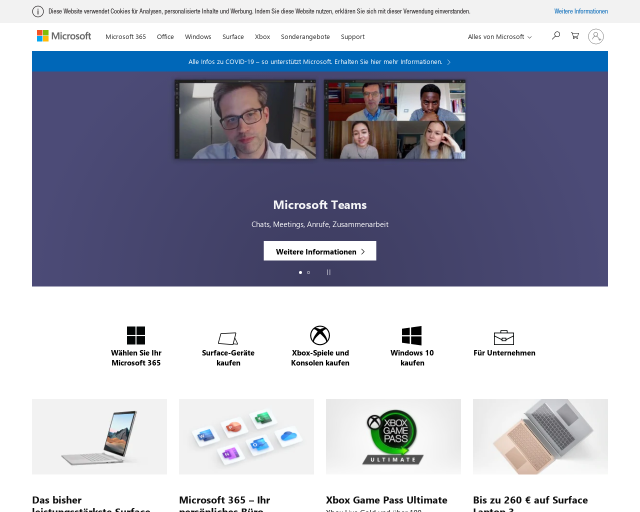

In [83]:
image_data = domain_utils.screenshot("microsoft.com")
from IPython.display import Image
with open('screenshot.png', 'wb') as f:
        f.write(image_data.content)

display(Image(filename='screenshot.png'))

In [201]:
#Morph Charts
morph = MorphCharts()
# Create Morph Chart for some aspect of our data
morph.display(data=query_data, chart_name="SigninsChart")

SigninsChart


In [ ]:
#Lateral Movement Graph